In [13]:
import numpy as np
import matplotlib.pyplot as plt
import csv
import pandas as pd

%matplotlib inline

# Logistic Regression for two classes

In [14]:
def load_dataset(file_name):
    # ...

    return pd.read_csv(file_name, header=None).values

In [15]:
def show_sample(data, label):
    """
    Shows an instance as a 2D image
    """
    # Make those columns into a array of 8-bits pixels
    # The pixel intensity values are integers from 0 to 255
    pixels = np.array(data, dtype='uint8')

    # Reshape the array into 28 x 28 array (2-dimensional array)
    n = int(np.sqrt(len(pixels)))
    assert n**2 == len(pixels)
    pixels = pixels.reshape(n, n)

    # Plot
    plt.title('Label is {label}'.format(label=label))
    plt.imshow(pixels, cmap='gray')
    plt.show()

In [16]:
def filter_set(dataset, l):
    """
    From the dataset, filters those instances whose labels are in the list given as argument
    """
    return dataset[ np.isin(dataset[:, 0], l) ]

In [17]:
def form_x_and_y(dataset):
    """
    Forms the dataframe as numpy arrays from the given dataset
    """
    
    return dataset[:, 1:], dataset[:, 0][:, np.newaxis]

In [18]:
def add_front_ones_column(x):
    """
    Adds a column of ones
    """
    ...
    return np.insert(x, 0, 1, axis=1)

In [19]:
def normalize(x):
    """
    Normalization means division by 255 -> values in [0, 1]
    """
    return x / 255.0

In [20]:
def sigmoid(z):
    return 1.0 / (1 + np.exp(-z))

def h(x, theta):
    return sigmoid(np.dot(x, theta))

In [21]:
def cost(x, y, theta, lmbda):
    """
    Cost function includes also regularization
    """
    t2 = theta.copy()
    t2[0, 0] = 0
    
    h_calc = h(x, theta)
    return - np.sum(y * np.log(h_calc) + (1 - y) * np.log(1 - h_calc)) / x.shape[0] + lmbda / 2 * np.sum(t2**2) / t2.shape[0]

def deltas(x, y, alpha, theta, lmbda):
    """
    Computation of deltas with regularization term
    """
    t2 = theta.copy()
    t2[0, 0] = 0
    return alpha * (np.sum((h(x, theta) - y) * x, axis=0)[:, np.newaxis] / x.shape[0] + lmbda * t2 / t2.shape[0])

In [10]:
# first, load the datasets
train_set = load_dataset('mnist_train.csv')
test_set = load_dataset('mnist_test.csv')

print(train_set.shape, test_set.shape)

(60000, 785) (10000, 785)


(12665, 785) (2115, 785)


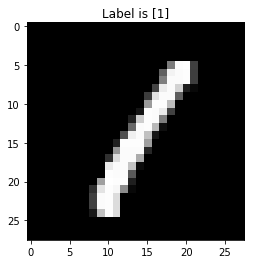

In [22]:
# filter only instances for zeroes and ones
two_train_set = filter_set(train_set, [0, 1])
two_test_set = filter_set(test_set, [0, 1])

print(two_train_set.shape, two_test_set.shape)

# form the training set
x_train, y_train = form_x_and_y(two_train_set)
assert np.shape(x_train) == (len(two_train_set), 28*28)
assert np.shape(y_train) == (len(two_train_set), 1)

# form the test set
x_test, y_test = form_x_and_y(two_test_set)
assert np.shape(x_test) == (len(two_test_set), 28*28)
assert np.shape(y_test) == (len(two_test_set), 1)

# just show a sample
show_sample(x_train[1], y_train[1])

# do the normalization
x_train = normalize(x_train)
x_test = normalize(x_test)

# add column of ones
x_train = add_front_ones_column(x_train)
x_test = add_front_ones_column(x_test)

last cost: 0.564846


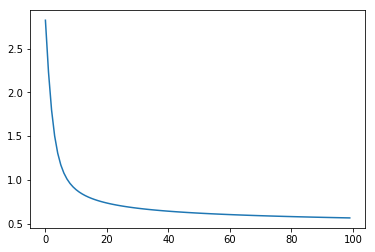

In [23]:
# set learning rate
alpha = 0.1

# set regularization coefficient
lmbda = 1

# we have m instances of n features each
# create theta as a vector (n x 1)
n = np.shape(x_train)[1]
theta = np.random.randn(n).reshape(n, 1)

# do the training
epochs = 100
values = []
for i in range(epochs):
    theta -= deltas(x_train, y_train, alpha, theta, lmbda)
    values.append(cost(x_train, y_train, theta, lmbda))
    
print("last cost: %g" % values[-1])
plt.plot(range(len(values)), values)
plt.show()

In [24]:
# compute the prediction for the test set
pred = h(x_test, theta)
pred_round = np.around(pred)
verificare = pred_round == y_test
print("accuracy: %2.2f%% for %d patterns" % (np.count_nonzero(verificare) / x_test.shape[0] * 100, x_test.shape[0]))

# confusion matrix
# true positive: y = 1 and pred = 1
# true negative: y = 0 and pred = 0
# false positive: y = 0 and pred = 1
# false negative: y = 1 and pred = 0
tp = np.count_nonzero(np.logical_and(y_test, pred_round))
tn = np.count_nonzero(np.logical_and(np.logical_not(y_test), np.logical_not(pred_round)))
fp = np.count_nonzero(np.logical_and(np.logical_xor(y_test, pred_round), y_test == False))
fn = np.count_nonzero(np.logical_and(np.logical_xor(y_test, pred_round), y_test == True))

import tableprint as tab
headers = ['Confusion Matrix', 'predicted: NO', 'predicted: YES', 'predicted: all'] 
table = [
    ['actual: NO', tn, fp, tn + fp],
    ['actual: YES', fn, tp, fn + tp],
    ['actual: all', tn + fn, fp + tp, tn + fn + fp + tp]]
tab.table(table, headers, width=16)


accuracy: 98.35% for 2115 patterns
╭──────────────────┬──────────────────┬──────────────────┬──────────────────╮
│ Confusion Matrix │  predicted: NO   │  predicted: YES  │  predicted: all  │
├──────────────────┼──────────────────┼──────────────────┼──────────────────┤
│       actual: NO │              968 │               12 │              980 │
│      actual: YES │               23 │             1112 │             1135 │
│      actual: all │              991 │             1124 │             2115 │
╰──────────────────┴──────────────────┴──────────────────┴──────────────────╯


# K-fold validation for 2 classes

In [29]:
x = x_train
y = y_train
# print(x.shape)
# print(y.shape)

k = 5
fold_size = int(x.shape[0] / k)
# print(fold_size)

alphas = np.array([0.1, 0.2, 0.3])
lambdas = np.array([0, 1, 10, 100])


average_acc = np.array([])

for alpha in alphas:
    for lmbda in lambdas:

        print("alpha = %f, lambda= %d" % (alpha, lmbda) )
        temp_accuracies = np.array([])
        for i in range(k):

            perm = np.arange(x.shape[0])
            np.random.shuffle(perm)

            x_rand = np.array_split(x[perm], k)
            y_rand = np.array_split(y[perm], k)

            x_train_k = np.concatenate(x_rand[:-1], axis=0)
            x_test_k = x_rand[-1]

            y_train_k = np.concatenate(y_rand[:-1], axis=0)
            y_test_k = y_rand[-1]

            # print(x_train_k.shape)
            # print(x_test_k.shape)
            # print(y_train_k.shape)
            # print(y_test_k.shape)

            # we have m instances of n features each
            # create theta as a vector (n x 1)
            n = np.shape(x_train_k)[1]
            theta = np.random.randn(n).reshape(n, 1)

            # do the training
            epochs = 100
            values = []
            for i in range(epochs):
                theta -= deltas(x_train_k, y_train_k, alpha, theta, lmbda)
                # values.append(cost(x_train, y_train, theta, lmbda))

            # print("last cost: %g" % values[-1])
            # plt.plot(range(len(values)), values)
            # plt.show()

            # compute the prediction for the test set
            pred = h(x_test_k, theta)
            pred_round = np.around(pred)
            verificare = pred_round == y_test_k
            accuracy = np.count_nonzero(verificare) / x_test_k.shape[0] * 100
            temp_accuracies = np.append(temp_accuracies, accuracy)
            print("accuracy: %2.2f%% for %d patterns" % (accuracy, x_test_k.shape[0]))
        
        current_avg = np.average(temp_accuracies)
        print("Average: %2.2f%% \n" % current_avg)
        average_acc = np.append(average_acc, current_avg)
        
average_acc = average_acc.reshape(3, 4)
print(average_acc)

alpha = 0.100000, lambda= 0
accuracy: 97.67% for 2533 patterns
accuracy: 97.63% for 2533 patterns
accuracy: 96.92% for 2533 patterns
accuracy: 97.83% for 2533 patterns
accuracy: 98.97% for 2533 patterns
Average: 97.80% 

alpha = 0.100000, lambda= 1
accuracy: 97.51% for 2533 patterns
accuracy: 98.66% for 2533 patterns
accuracy: 97.24% for 2533 patterns
accuracy: 97.83% for 2533 patterns
accuracy: 97.08% for 2533 patterns
Average: 97.66% 

alpha = 0.100000, lambda= 10
accuracy: 96.60% for 2533 patterns
accuracy: 98.18% for 2533 patterns
accuracy: 97.51% for 2533 patterns
accuracy: 97.87% for 2533 patterns
accuracy: 98.03% for 2533 patterns
Average: 97.64% 

alpha = 0.100000, lambda= 100
accuracy: 99.05% for 2533 patterns
accuracy: 98.78% for 2533 patterns
accuracy: 98.82% for 2533 patterns
accuracy: 98.86% for 2533 patterns
accuracy: 99.37% for 2533 patterns
Average: 98.97% 

alpha = 0.200000, lambda= 0
accuracy: 97.63% for 2533 patterns
accuracy: 98.74% for 2533 patterns
accuracy: 97.75

# Multinomial Logistic Regression

In [12]:
def one_hot(y, classes):
    '''
    Recieved the y vector of labels and number of classes
    Returns a (m x k) matrix of the one-hot representation of every label in y
    '''
    one_hot_y = np.zeros((y.shape[0], classes))
    one_hot_y[np.arange(y.shape[0]), y.flat] = 1
    return one_hot_y

def prod(x, theta):
    '''
    Dot product of x and theta
    Returns a (m x k) matrix with the k probabilities for every x
    '''
    #return np.prod(x, theta) ???
    return np.dot(x, theta)

def softmax(x, theta):
    """"
    Softmax is computed using a 2D theta (n x k), where k = classes
    Returns a (m x k) matrix
    """
    rez = np.exp(prod(x, theta))
    return rez / np.sum(rez, axis=1)[:, np.newaxis]

def cost(x, y, theta, lmbda):
    """
    Cost includes regularization
    """
    '''
    a doua suma: fiecare log de softmax se inmulteste cu 0 daca x nu e de label y si cu 1 altfel
    practic a doua suma doar selecteaza acel softmax maxim din vectorul de probabilitati al unui x
    si atunci implementarea implica suma logaritmilor maximilor de pe fiecare linie
    
    se poate implementa formula dupa cum e in curs daca inmultim Hadamard fiecare x cu one-hotul corespunzator
    dar nu prea mi se pare ca se poate vectoriza
    
    de fapt, nu ai garantia ca cel de clasa l e maximul, mai ales cu theta neantrenat
    si atunci nu merge si ar trebui facut cu one_hot daca se poate, dar nu vad cum se vectorizeaza
    
    np.sum(np.log(np.amax(softmax(x, theta), axis=1)))
    '''
    t2 = theta.copy()
    t2[0, :] = 0
    
    #suma1 = np.sum(one_hot(y, theta.shape[1]) * np.log(softmax(x, theta)), axis=1)
    suma1 = np.sum(y * np.log(softmax(x, theta)), axis=1)
    return - np.sum(suma1) / x.shape[0] + lmbda / 2 * np.sum(t2**2)

def deltas(x, y, theta, lmbda):
    """
    Compute the deltas
    """
    m, n = np.shape(x)
    n, k = np.shape(theta)
    
    x2 = x.reshape((m, 1, n))
    
    tensor = x2 * (y - softmax(x, theta)).reshape((m, k, 1))
    
    # fara regularizarea termenului liber (?)
    t2 = theta.copy()
    t2[0, :] = 0
    
    return - np.sum(tensor, axis=0).T / m + lmbda * t2

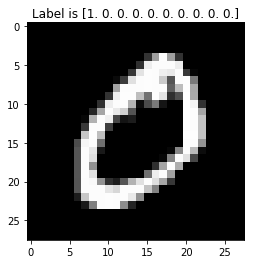

In [13]:
# classes
k = 10

x_train, y_train = form_x_and_y(train_set)
assert np.shape(x_train) == (len(train_set), 28*28)
assert np.shape(y_train) == (len(train_set), 1)

x_test, y_test = form_x_and_y(test_set)
assert np.shape(x_test) == (len(test_set), 28*28)
assert np.shape(y_test) == (len(test_set), 1)

y_train = one_hot(y_train, k)
y_test = one_hot(y_test, k)
show_sample(x_train[1], y_train[1])

x_train = normalize(x_train)
x_test = normalize(x_test)

x_train = add_front_ones_column(x_train)
x_test = add_front_ones_column(x_test)

last cost: 1.49198


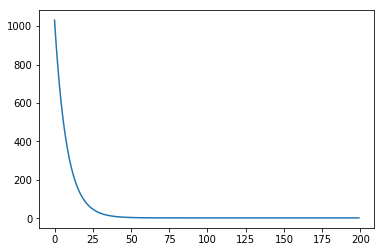

In [17]:
k = 10
lmbda = 0.3
alpha = 0.2
m, n = np.shape(x_train)
theta = np.random.randn(n, k)

epochs = 100
values = []
for i in range(epochs):
    theta -= alpha * deltas(x_train, y_train, theta, lmbda)
    values.append(cost(x_train, y_train, theta, lmbda))
    
print("last cost: %g" % values[-1])
plt.plot(range(len(values)), values)
plt.show()

In [18]:
pred = np.zeros((x_test.shape[0], k))
pred[np.arange(x_test.shape[0]), np.argmax(softmax(x_test, theta), axis=1)] = 1
nbCorrect = np.count_nonzero((pred == y_test).all(axis=1))

print("Test accuracy: %2.2f%%" % (nbCorrect / y_test.shape[0] * 100))

Test accuracy: 83.54%


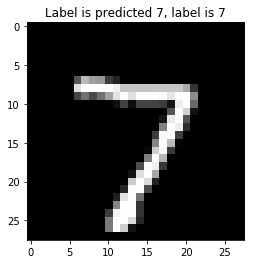

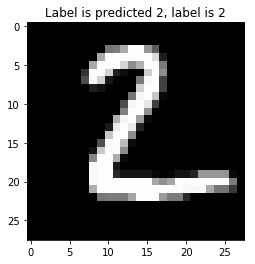

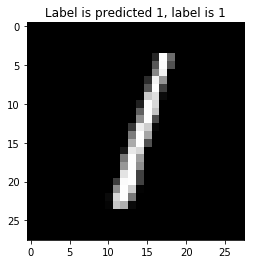

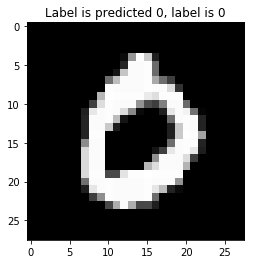

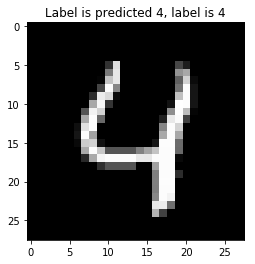

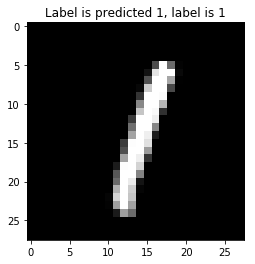

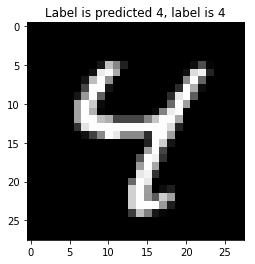

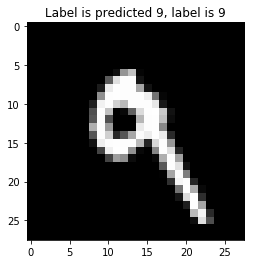

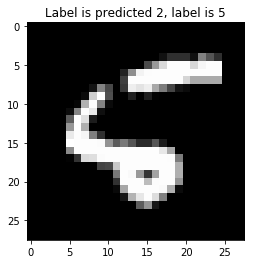

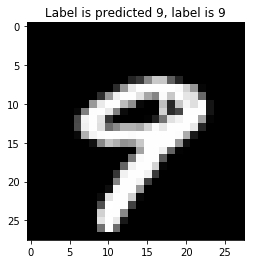

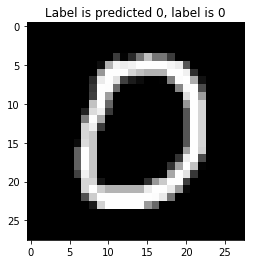

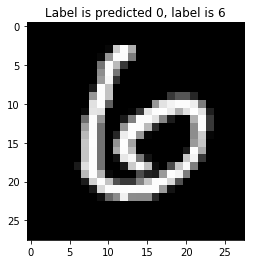

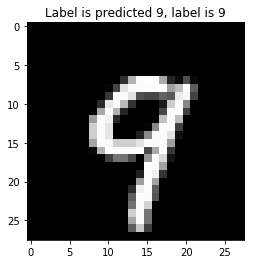

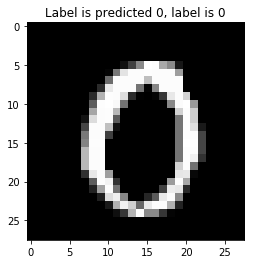

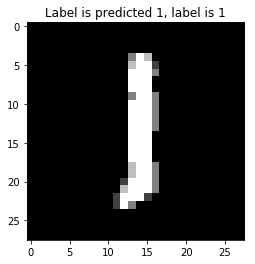

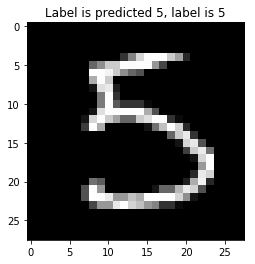

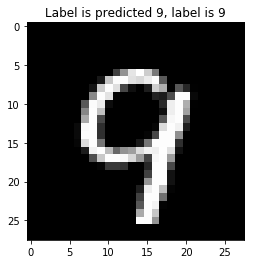

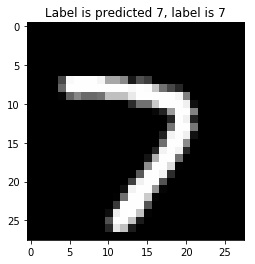

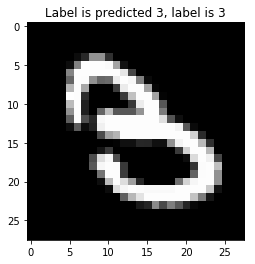

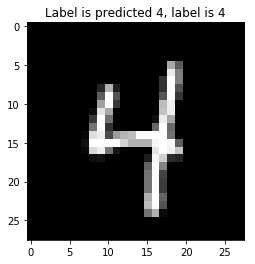

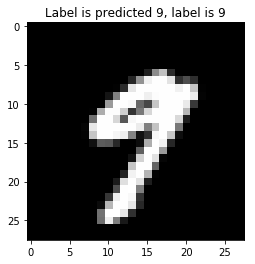

In [50]:
# you can change the code however you like, just fill in the dots
for i in range(21):
    show_sample(
        255*x_test[i, 1:], 
        str.format("predicted {0}, label is {1}", np.argmax(pred[i]), np.argmax(y_test[i]))
    )


# K-fold validation for 10 classes

In [14]:
x = x_train
y = y_train
# print(x.shape)
# print(y.shape)

k = 5
fold_size = int(x.shape[0] / k)
# print(fold_size)

alphas = np.array([0.1, 0.2, 0.3])
lambdas = np.array([0, 1, 10, 100])


average_acc = np.array([])

for alpha in alphas:
    for lmbda in lambdas:

        print("alpha = %f, lambda= %d" % (alpha, lmbda) )
        temp_accuracies = np.array([])
        for i in range(k):

            perm = np.arange(x.shape[0])
            np.random.shuffle(perm)

            x_rand = np.array_split(x[perm], k)
            y_rand = np.array_split(y[perm], k)

            x_train_k = np.concatenate(x_rand[:-1], axis=0)
            x_test_k = x_rand[-1]

            y_train_k = np.concatenate(y_rand[:-1], axis=0)
            y_test_k = y_rand[-1]

            # print(x_train_k.shape)
            # print(x_test_k.shape)
            # print(y_train_k.shape)
            # print(y_test_k.shape)

            # we have m instances of n features each
            # create theta as a vector (n x 1)
            n = np.shape(x_train_k)[1]
            theta = np.random.randn(n).reshape(n, 1)

            # do the training
            epochs = 100
            values = []
            for i in range(epochs):
                theta -= alpha * deltas(x_train_k, y_train_k, theta, lmbda)
                # values.append(cost(x_train, y_train, theta, lmbda))

            # print("last cost: %g" % values[-1])
            # plt.plot(range(len(values)), values)
            # plt.show()

            # compute the prediction for the test set
            pred = np.zeros((x_test_k.shape[0], k))
            pred[np.arange(x_test_k.shape[0]), np.argmax(softmax(x_test_k, theta), axis=1)] = 1
            nbCorrect = np.count_nonzero((pred == y_test_k).all(axis=1))
            accuracy = nbCorrect / y_test_k.shape[0] * 100
            temp_accuracies = np.append(temp_accuracies, accuracy)
            print("accuracy: %2.2f%% for %d patterns" % (accuracy, x_test_k.shape[0]))
        
        current_avg = np.average(temp_accuracies)
        print("Average: %2.2f%% \n" % current_avg)
        average_acc = np.append(average_acc, current_avg)
        
average_acc = average_acc.reshape(3, 4)
print(average_acc)

alpha = 0.100000, lambda= 0


ValueError: cannot reshape array of size 480000 into shape (48000,1,1)